In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

## 💽 Dataset
Our dataset consists of images of various plant species. Each species is organized into a separate folder within the main data directory. We will use this structured data to train and validate our model.

In [2]:
# Set up the main directory containing subdirectories for each plant species
main_data_dir = 'dataset/Medicinal Leaf Images'
batch_size = 32
num_classes = len(os.listdir(main_data_dir))
epochs = 10


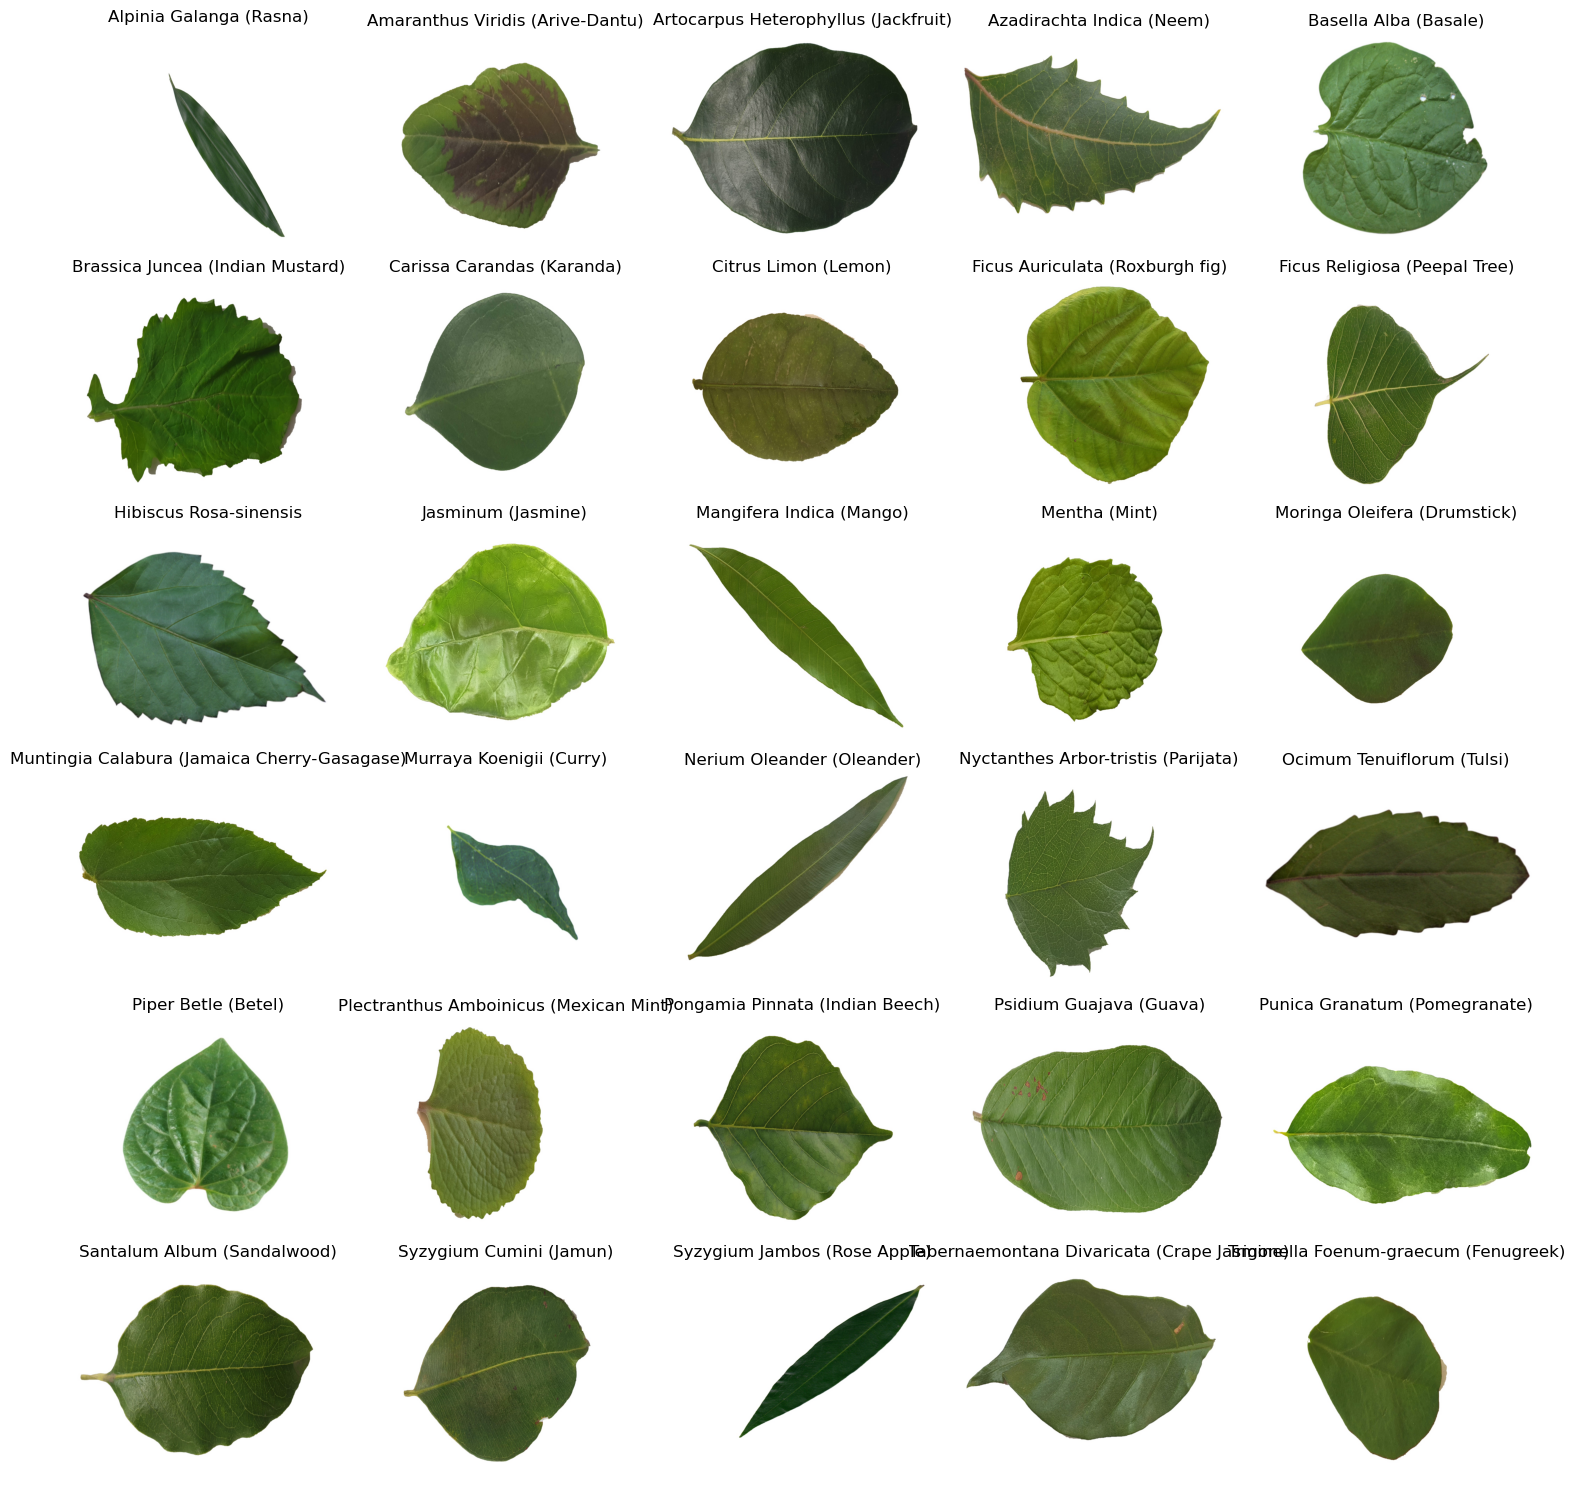

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

# List all subdirectories (class folders) in the main directory
class_folders = os.listdir(main_data_dir)

# Set the number of images per row
images_per_row = 5

# Calculate the number of rows needed
num_rows = math.ceil(len(class_folders) / images_per_row)

# Create a grid of subplots
fig, axs = plt.subplots(num_rows, images_per_row, figsize=(15, 15))

# Display images in rows with titles
for i, class_folder in enumerate(class_folders):
    # Get the first image file in the class folder
    class_folder_path = os.path.join(main_data_dir, class_folder)
    image_files = [f for f in os.listdir(class_folder_path) if f.endswith('.jpg')]
    if image_files:
        first_image_path = os.path.join(class_folder_path, image_files[0])
        
        # Load the image
        img = mpimg.imread(first_image_path)
        
        # Calculate the row and column indices for the subplot
        row = i // images_per_row
        col = i % images_per_row
        
        # Display the image in the corresponding subplot
        axs[row, col].imshow(img)
        axs[row, col].set_title(class_folder)
        axs[row, col].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## 🧽 Data Preprocessing
- Load and preprocess the images using the `ImageDataGenerator` class from TensorFlow.
- Split the data into training and validation sets.
- Normalize the pixel values to the range [0, 1].
- Apply data augmentation techniques to enhance model generalization.

In [4]:
# Split ratio between training and validation data
split_ratio = 0.8

# Create ImageDataGenerator with data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=1 - split_ratio  # Set validation split
)


In [5]:

# Load and preprocess training data using the generator
train_generator = train_datagen.flow_from_directory(
    main_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Specify training subset
)

# Load and preprocess validation data using the generator
validation_generator = train_datagen.flow_from_directory(
    main_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Specify validation subset
)

Found 3331 images belonging to 30 classes.
Found 810 images belonging to 30 classes.


In [6]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout


## 🏛️ Model Architecture
- Utilize the MobileNetV2 pre-trained model as the base architecture.
- Add custom layers on top to adapt the model for plant species classification.
- Incorporate a global average pooling layer and dropout for regularization.
- Compile the model using appropriate loss and optimizer functions.

## 🏋️‍♀️ Model Training
- Train the model using the preprocessed training data.
- Monitor training progress using accuracy and loss metrics.
- Validate the model on the separate validation set.
- Visualize training and validation curves to assess model performance.

In [7]:
# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/10
104/104 [==============================] - 143s 1s/step - loss: 1.1602 - accuracy: 0.6681 - val_loss: 0.4109 - val_accuracy: 0.8888
Epoch 2/10
104/104 [==============================] - 119s 1s/step - loss: 0.3494 - accuracy: 0.8957 - val_loss: 0.2706 - val_accuracy: 0.9137
Epoch 3/10
104/104 [==============================] - 117s 1s/step - loss: 0.2346 - accuracy: 0.9282 - val_loss: 0.2496 - val_accuracy: 0.9187
Epoch 4/10
104/104 [==============================] - 120s 1s/step - loss: 0.1848 - accuracy: 0.9430 - val_loss: 0.1623 - val_accuracy: 0.9463
Epoch 5/10
104/104 [==============================] - 121s 1s/step - loss: 0.1563 - accuracy: 0.9542 - val_loss: 0.2030 - val_accuracy: 0.9337
Epoch 6/10
104/104 [==============================] - 121s 1s/step - loss: 0.1307 - accuracy: 0.9615 - val_loss: 0.1606 - val_accuracy: 0.9475
Epoch 7/10
104/104 [==============================] - 119s 1s/step - loss: 0.10

In [9]:
# Save the trained model
model.save('plant_model2.h5')

##🧭 Inference
- Load the trained model to make predictions on new images.
- Preprocess the input image for the model.
- Use the model to predict the plant species present in the image.

In [10]:
# Create label mapping based on subdirectory names
label_mapping = {i: label for i, label in enumerate(sorted(os.listdir(main_data_dir)))}

In [11]:
label_mapping

{0: 'Alpinia Galanga (Rasna)',
 1: 'Amaranthus Viridis (Arive-Dantu)',
 2: 'Artocarpus Heterophyllus (Jackfruit)',
 3: 'Azadirachta Indica (Neem)',
 4: 'Basella Alba (Basale)',
 5: 'Brassica Juncea (Indian Mustard)',
 6: 'Carissa Carandas (Karanda)',
 7: 'Citrus Limon (Lemon)',
 8: 'Ficus Auriculata (Roxburgh fig)',
 9: 'Ficus Religiosa (Peepal Tree)',
 10: 'Hibiscus Rosa-sinensis',
 11: 'Jasminum (Jasmine)',
 12: 'Mangifera Indica (Mango)',
 13: 'Mentha (Mint)',
 14: 'Moringa Oleifera (Drumstick)',
 15: 'Muntingia Calabura (Jamaica Cherry-Gasagase)',
 16: 'Murraya Koenigii (Curry)',
 17: 'Nerium Oleander (Oleander)',
 18: 'Nyctanthes Arbor-tristis (Parijata)',
 19: 'Ocimum Tenuiflorum (Tulsi)',
 20: 'Piper Betle (Betel)',
 21: 'Plectranthus Amboinicus (Mexican Mint)',
 22: 'Pongamia Pinnata (Indian Beech)',
 23: 'Psidium Guajava (Guava)',
 24: 'Punica Granatum (Pomegranate)',
 25: 'Santalum Album (Sandalwood)',
 26: 'Syzygium Cumini (Jamun)',
 27: 'Syzygium Jambos (Rose Apple)',
 28: 

In [12]:
# Test Image
image_path = 'image (1).png'

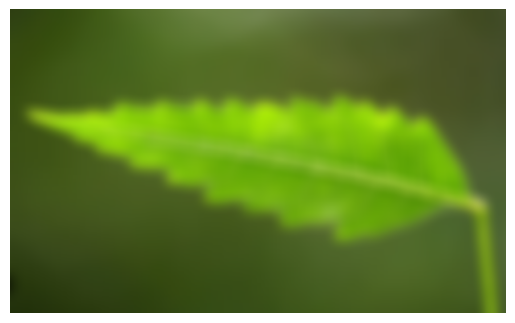

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the image
img = mpimg.imread(image_path)

plt.imshow(img)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load the trained model
model = tf.keras.models.load_model('plant_identification_model2.h5')

# Load and preprocess the image
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    preprocessed_image = preprocess_input(image_array)
    return preprocessed_image

# Perform prediction
def predict_plant(image_path, label_mapping):
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)
    
    # Map model's numeric predictions to labels
    predicted_label_index = np.argmax(predictions)
    predicted_label = label_mapping[predicted_label_index]
    confidence = predictions[0][predicted_label_index]
    
    return predicted_label, confidence

# Provide the path to the image you want to classify
predicted_label, confidence = predict_plant(image_path, label_mapping)

# Print the prediction
print(f"Predicted Label: {predicted_label}")
print(f"Confidence: {confidence:.2f}")


1/1 [==============================] - 1s 542ms/step
Predicted Label: Artocarpus Heterophyllus (Jackfruit)
Confidence: 0.72


## 📈 Results and Evaluation
- Analyze the training and validation accuracy/loss curves.
- Evaluate the model's performance using various metrics (accuracy, precision, recall).
- Interpret and discuss the results, highlighting any challenges faced.

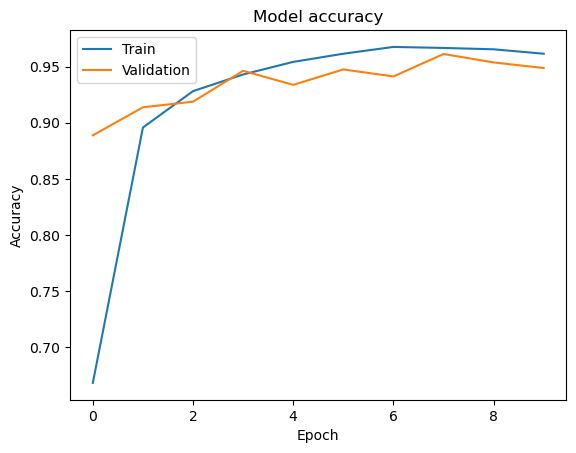

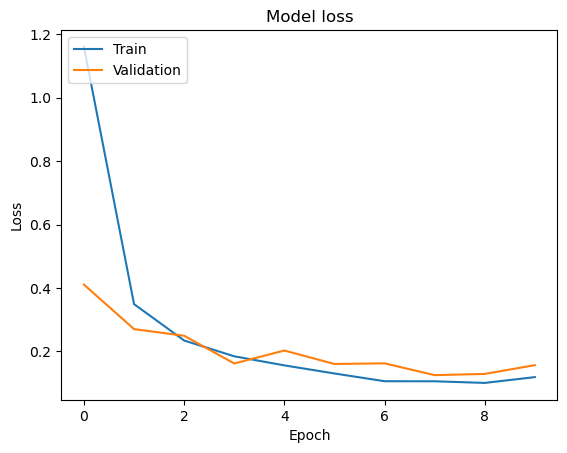

In [15]:
## Results and Evaluation
### Training and Validation Curves
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Conclusion
In this notebook, we've successfully built and trained a deep learning model to identify plant species from images. We've covered data preprocessing, model architecture, training, evaluation, and inference steps. The final model can be used to classify plant species from new images effectively.

## Future Work
- Experiment with different architectures and hyperparameters for potential performance improvements.
- Gather more diverse and extensive labeled data to enhance model robustness.
- Explore advanced techniques such as transfer learning from larger datasets.